In [1]:
import pandas as pd
import numpy as np
import fnmatch
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.stats import ttest_ind

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor



In [2]:
def merge_csv_files(directory, output_filename):
    # Use glob to match all csv files in the directory
    csv_files = glob.glob(os.path.join(directory, '*enriched.csv'))
    
    # Initialize an empty list to store dataframes
    df_list = []
    
    # Loop through the files and read them into pandas dataframes
    for filename in csv_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        df_list.append(df)
    
    # Concatenate all the dataframes in the list
    merged_df = pd.concat(df_list, axis=0, ignore_index=True)
    
    # Write the merged dataframe to a new csv file
    merged_df.to_csv(output_filename, index=False)

    return merged_df

In [3]:
os.getcwd()

'/Users/tonychu/Git Repository/Cybersecurity Threat Analysis'

In [4]:
directory = '/Users/tonychu/Git Repository/Cybersecurity Threat Analysis'
output_filename = 'merged.csv'
df = merge_csv_files(directory, output_filename)

In [5]:
df.head()

,cve_id,vendor_project,product,vulnerability_name,date_added,short_description,required_action,due_date,notes,grp,pub_date,cvss,cwe,vector,complexity,severity
0,CVE-2021-27104,accellion,FTA,Accellion FTA OS Command Injection Vulnerability,2021-11-03,Accellion FTA 9_12_370 and earlier is affected...,Apply updates per vendor instructions.,2021-11-17,NaN,1,2021-02-16,9.8,CWE-78,NETWORK,LOW,CRITICAL
1,CVE-2021-27102,accellion,FTA,Accellion FTA OS Command Injection Vulnerability,2021-11-03,Accellion FTA 9_12_411 and earlier is affected...,Apply updates per vendor instructions.,2021-11-17,NaN,1,2021-02-16,7.8,CWE-78,LOCAL,LOW,HIGH
2,CVE-2021-27101,accellion,FTA,Accellion FTA SQL Injection Vulnerability,2021-11-03,Accellion FTA 9_12_370 and earlier is affected...,Apply updates per vendor instructions.,2021-11-17,NaN,1,2021-02-16,9.8,CWE-89,NETWORK,LOW,CRITICAL
3,CVE-2021-27103,accellion,FTA,Accellion FTA SSRF Vulnerability,2021-11-03,Accellion FTA 9_12_411 and earlier is affected...,Apply updates per vendor instructions.,2021-11-17,NaN,1,2021-02-16,9.8,CWE-918,NETWORK,LOW,CRITICAL
4,CVE-2021-21017,adobe,Acrobat and Reader,Adobe Acrobat and Reader Heap-based Buffer Ove...,2021-11-03,Acrobat Reader DC versions versions 2020.013.2...,Apply updates per vendor instructions.,2021-11-17,NaN,1,2021-02-11,8.8,CWE-787,NETWORK,LOW,HIGH


Exploratory Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cve_id              3984 non-null   object 
 1   vendor_project      3984 non-null   object 
 2   product             3979 non-null   object 
 3   vulnerability_name  3984 non-null   object 
 4   date_added          3984 non-null   object 
 5   short_description   3954 non-null   object 
 6   required_action     3984 non-null   object 
 7   due_date            3984 non-null   object 
 8   notes               77 non-null     object 
 9   grp                 3984 non-null   int64  
 10  pub_date            3106 non-null   object 
 11  cvss                2484 non-null   float64
 12  cwe                 3090 non-null   object 
 13  vector              2484 non-null   object 
 14  complexity          2484 non-null   object 
 15  severity            2484 non-null   object 
dtypes: flo

In [7]:
df = df.drop(['notes','short_description'], axis = 1)
df[['date_added', 'due_date','pub_date']] = df[['date_added', 'due_date','pub_date']].apply(pd.to_datetime)

In [8]:
def correlation_p_value(var_1, var_2):# Example: Compare means of a numerical column across missing and non-missing groups of another column
    missing_group = df[df[var_1].isnull()]
    non_missing_group = df[~df[var_1].isnull()]

    # You can use a t-test for numerical variables or chi-squared test for categorical variables
    

    # Assuming 'numerical_column' is another column you're examining
    t_stat, p_value = ttest_ind(missing_group[var_2].dropna(), non_missing_group[var_2])

    # print(f'T-test P-value: {p_value}')
    return p_value

correlation_p_value('complexity', 'cvss')

nan

In [9]:
df.loc[df['product'].isnull(), 'product'] = 'Others'
df.loc[df['product'].isnull(), 'cvss'] = 9.8
df.loc[df['product'].isnull(), 'cwe'] = 'CWE-89'
df.loc[df['product'].isnull(), 'vector'] = 'NETWORK'
df.loc[df['product'].isnull(), 'complexity'] = 'LOW'
df.loc[df['product'].isnull(), 'severity'] = 'CRITICAL'

In [10]:
imputer = IterativeImputer(estimator=RandomForestRegressor(), random_state=0, max_iter=10)

# It's crucial to select only numeric columns for MICE; here's a simplified approach focusing on 'cvss'
numeric_columns = ['grp','cvss']  # You can add more numeric columns if applicable
df_numeric = df[numeric_columns]

# Perform the imputation
imputed_data = imputer.fit_transform(df_numeric)
df[numeric_columns] = imputed_data

# Check to ensure the imputation was successful
df.isnull().sum()

/Users/tonychu/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


cve_id                   0
vendor_project           0
product                  0
vulnerability_name       0
date_added               0
required_action          0
due_date                 0
grp                      0
pub_date               878
cvss                     0
cwe                    894
vector                1500
complexity            1500
severity              1500
dtype: int64

In [11]:
df_remove = df[df.cwe.isnull()]
df_dropped = df.drop(index=df_remove.index)
df_dropped

,cve_id,vendor_project,product,vulnerability_name,date_added,required_action,due_date,grp,pub_date,cvss,cwe,vector,complexity,severity
0,CVE-2021-27104,accellion,FTA,Accellion FTA OS Command Injection Vulnerability,2021-11-03,Apply updates per vendor instructions.,2021-11-17,1.0,2021-02-16,9.8,CWE-78,NETWORK,LOW,CRITICAL
1,CVE-2021-27102,accellion,FTA,Accellion FTA OS Command Injection Vulnerability,2021-11-03,Apply updates per vendor instructions.,2021-11-17,1.0,2021-02-16,7.8,CWE-78,LOCAL,LOW,HIGH
2,CVE-2021-27101,accellion,FTA,Accellion FTA SQL Injection Vulnerability,2021-11-03,Apply updates per vendor instructions.,2021-11-17,1.0,2021-02-16,9.8,CWE-89,NETWORK,LOW,CRITICAL
3,CVE-2021-27103,accellion,FTA,Accellion FTA SSRF Vulnerability,2021-11-03,Apply updates per vendor instructions.,2021-11-17,1.0,2021-02-16,9.8,CWE-918,NETWORK,LOW,CRITICAL
4,CVE-2021-21017,adobe,Acrobat and Reader,Adobe Acrobat and Reader Heap-based Buffer Ove...,2021-11-03,Apply updates per vendor instructions.,2021-11-17,1.0,2021-02-11,8.8,CWE-787,NETWORK,LOW,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376,CVE-2019-18988,teamviewer,TeamViewer Desktop,TeamViewer Desktop Bypass Remote Login,2021-11-03,Apply updates per vendor instructions.,2022-05-03,1.0,2020-02-07,7.0,CWE-521,LOCAL,HIGH,HIGH
3415,CVE-2020-11261,qualcomm,"Snapdragon Auto, Snapdragon Compute, Snapdrago...",Qualcomm Multiple Chipsets Improper Input Vali...,2021-12-01,Apply updates per vendor instructions.,2022-06-01,3.0,2021-06-09,7.8,CWE-20,LOCAL,LOW,HIGH
3460,CVE-2020-13671,drupal,Drupal core,Drupal core Un-restricted Upload of File,2022-01-18,Apply updates per vendor instructions.,2022-07-18,7.0,2020-11-20,8.8,CWE-434,NETWORK,LOW,HIGH
3483,CVE-2017-0262,microsoft,Office,Microsoft Office Remote Code Execution Vulnera...,2022-02-10,Apply updates per vendor instructions.,2022-08-10,11.0,2017-05-12,7.8,NVD-CWE-noinfo,LOCAL,LOW,HIGH


In [12]:
unique_attack = df_dropped.groupby('date_added', as_index=False)['cve_id'].nunique()
unique_attack

,date_added,cve_id
0,2021-11-03,287
1,2021-11-17,4
2,2021-12-01,5
3,2021-12-10,13
4,2021-12-15,2
5,2022-01-10,15
6,2022-01-18,13
7,2022-01-21,4
8,2022-01-28,8
9,2022-02-04,1


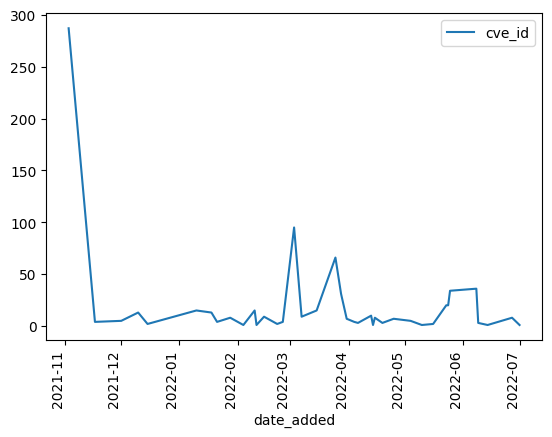

In [13]:
unique_attack.plot('date_added','cve_id')
plt.xticks(rotation = 90)
plt.show()

In [14]:
df.columns

Index(['cve_id', 'vendor_project', 'product', 'vulnerability_name',
       'date_added', 'required_action', 'due_date', 'grp', 'pub_date', 'cvss',
       'cwe', 'vector', 'complexity', 'severity'],
      dtype='object')

In [15]:
categorical_columns = ['vector', 'severity', 'complexity']

# Convert categorical columns to dummy variables
data_dummies = pd.get_dummies(df_dropped, columns=categorical_columns)

# Display the first few rows to verify the transformation
data_dummies.head()

,cve_id,vendor_project,product,vulnerability_name,date_added,required_action,due_date,grp,pub_date,cvss,cwe,vector_ADJACENT_NETWORK,vector_LOCAL,vector_NETWORK,severity_CRITICAL,severity_HIGH,severity_LOW,severity_MEDIUM,complexity_HIGH,complexity_LOW
0,CVE-2021-27104,accellion,FTA,Accellion FTA OS Command Injection Vulnerability,2021-11-03,Apply updates per vendor instructions.,2021-11-17,1.0,2021-02-16,9.8,CWE-78,False,False,True,True,False,False,False,False,True
1,CVE-2021-27102,accellion,FTA,Accellion FTA OS Command Injection Vulnerability,2021-11-03,Apply updates per vendor instructions.,2021-11-17,1.0,2021-02-16,7.8,CWE-78,False,True,False,False,True,False,False,False,True
2,CVE-2021-27101,accellion,FTA,Accellion FTA SQL Injection Vulnerability,2021-11-03,Apply updates per vendor instructions.,2021-11-17,1.0,2021-02-16,9.8,CWE-89,False,False,True,True,False,False,False,False,True
3,CVE-2021-27103,accellion,FTA,Accellion FTA SSRF Vulnerability,2021-11-03,Apply updates per vendor instructions.,2021-11-17,1.0,2021-02-16,9.8,CWE-918,False,False,True,True,False,False,False,False,True
4,CVE-2021-21017,adobe,Acrobat and Reader,Adobe Acrobat and Reader Heap-based Buffer Ove...,2021-11-03,Apply updates per vendor instructions.,2021-11-17,1.0,2021-02-11,8.8,CWE-787,False,False,True,False,True,False,False,False,True


In [16]:
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3090 entries, 0 to 3501
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   cve_id                   3090 non-null   object        
 1   vendor_project           3090 non-null   object        
 2   product                  3090 non-null   object        
 3   vulnerability_name       3090 non-null   object        
 4   date_added               3090 non-null   datetime64[ns]
 5   required_action          3090 non-null   object        
 6   due_date                 3090 non-null   datetime64[ns]
 7   grp                      3090 non-null   float64       
 8   pub_date                 3090 non-null   datetime64[ns]
 9   cvss                     3090 non-null   float64       
 10  cwe                      3090 non-null   object        
 11  vector_ADJACENT_NETWORK  3090 non-null   bool          
 12  vector_LOCAL             3090 non-null 

In [17]:
correlation_matrix = data_dummies.select_dtypes(include = ['float64','bool','datetime64']).corr()

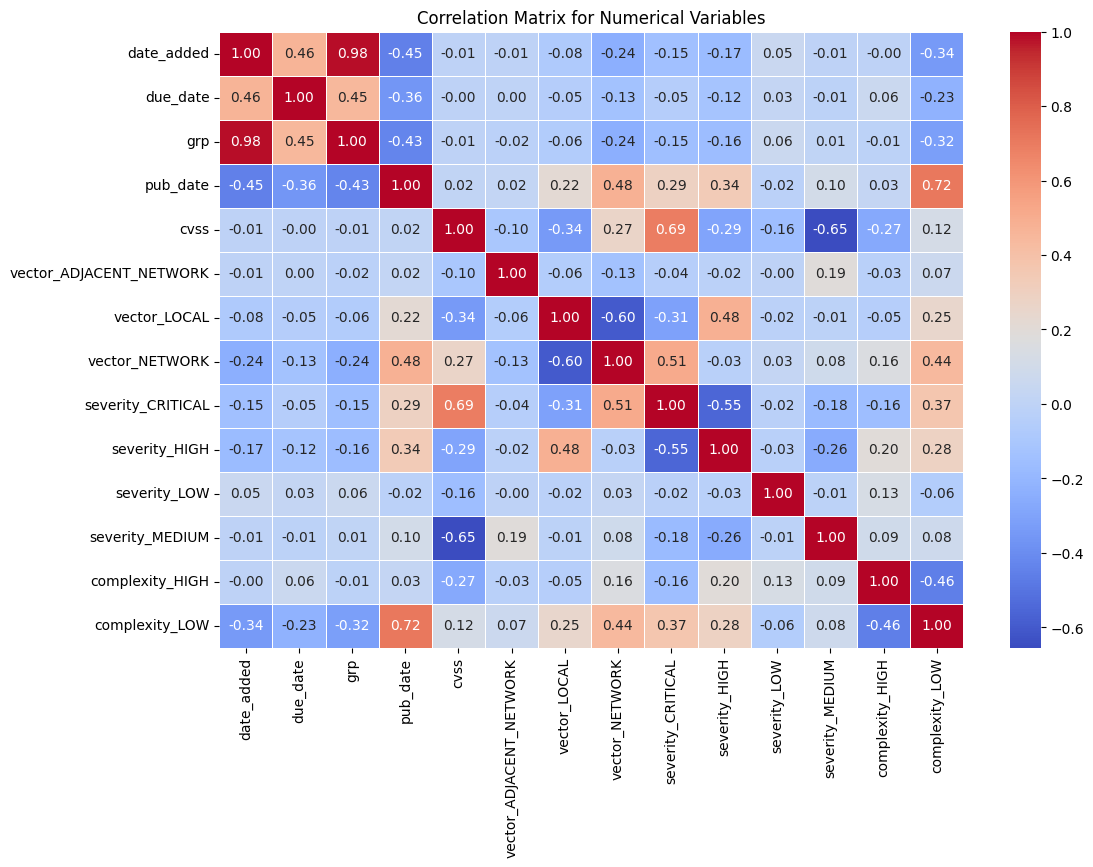

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Numerical Variables')
plt.show()

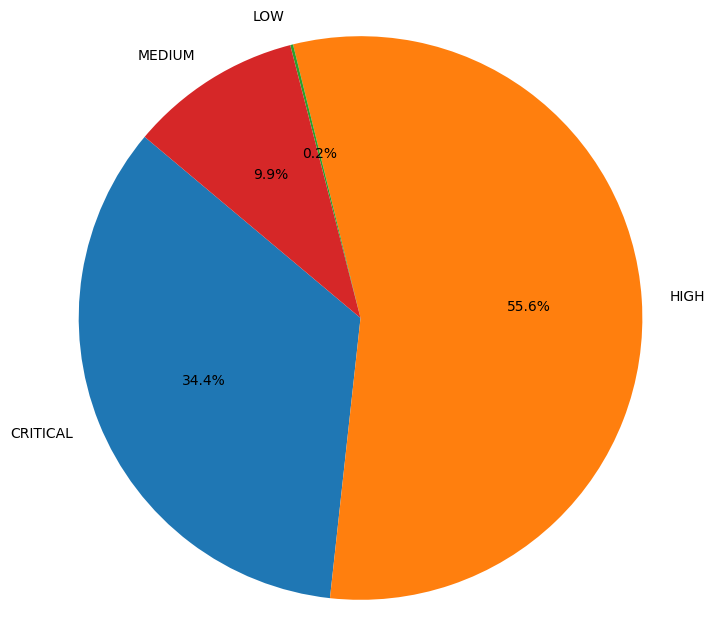

In [19]:
severity_summary=df_dropped.groupby('severity')['cve_id'].count()
# Extract labels and sizes
labels = severity_summary.index
sizes = severity_summary.values

# Create the pie chart
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Display the chart
plt.show()

In [20]:
due_date_success_rate = df_dropped.due_date.notnull().sum()/len(df_dropped)*100
string=f"Proportion of vulnerabilities with due dates met: {due_date_success_rate}%"
print(string)

Proportion of vulnerabilities with due dates met: 100.0%


(-1.0999994416459886,
 1.0999981934904253,
 -1.0999997561408144,
 1.0999952410983052)

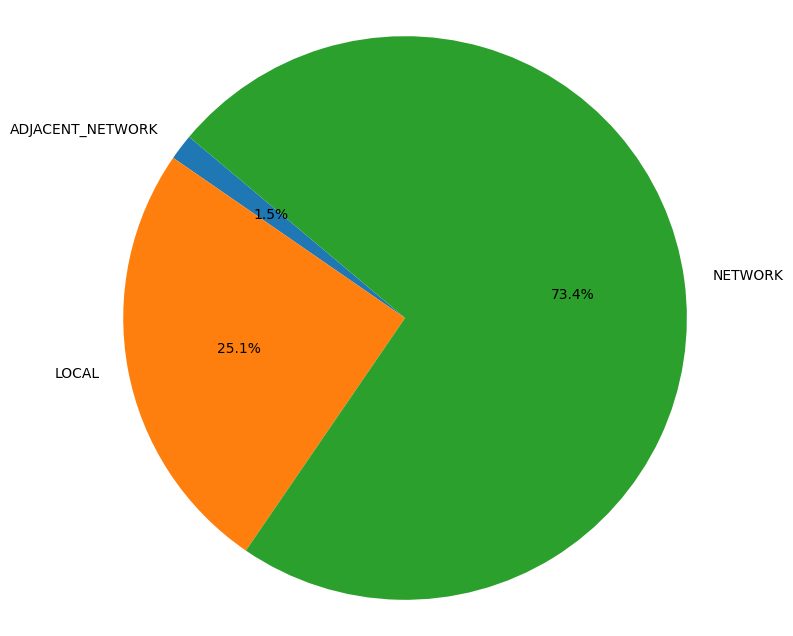

In [21]:
vector_summary = df_dropped.groupby('vector')['cve_id'].count()
# Extract labels and sizes
labels = vector_summary.index
sizes = vector_summary.values

# Create the pie chart
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

(-1.0999997783291282,
 1.0999999459365497,
 -1.0999998910755162,
 1.099999738015679)

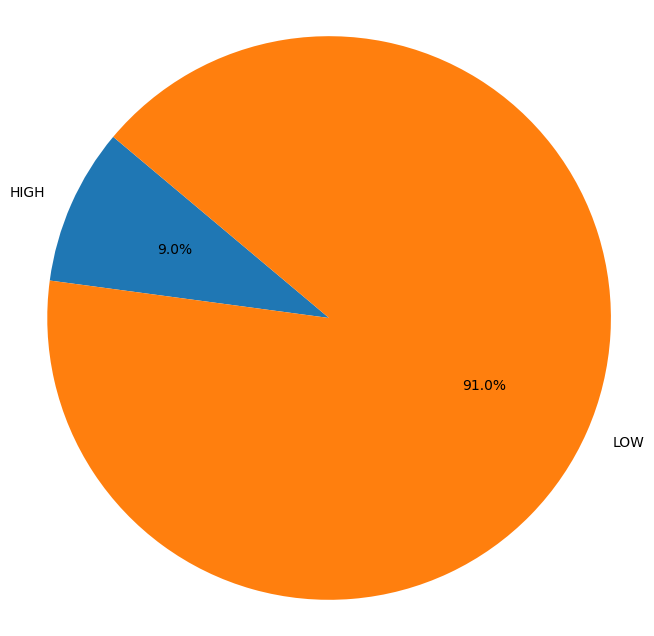

In [22]:
complexity_summary = df_dropped.groupby('complexity')['cve_id'].count()
# Extract labels and sizes
labels = complexity_summary.index
sizes = complexity_summary.values

# Create the pie chart
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

Text(0, 0.5, 'Counts')

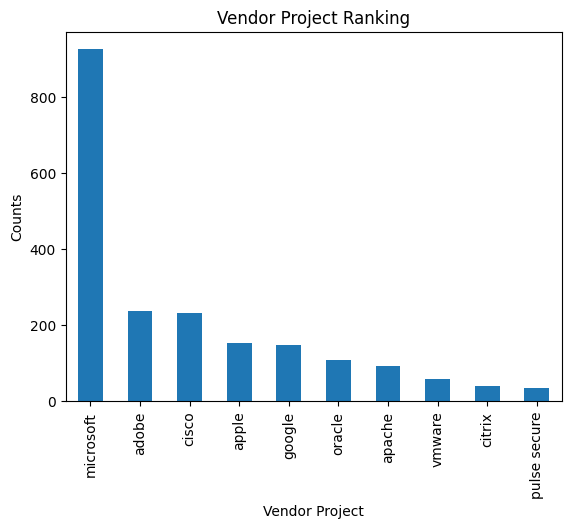

In [23]:
project_rank = df_dropped.groupby('vendor_project', as_index=False)['cve_id'].count().sort_values(by = 'cve_id', ascending=False)
project_rank.head(10).plot(kind='bar', x='vendor_project', y='cve_id', legend=False)

# Adding titles and labels
plt.title('Vendor Project Ranking')
plt.xlabel('Vendor Project')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

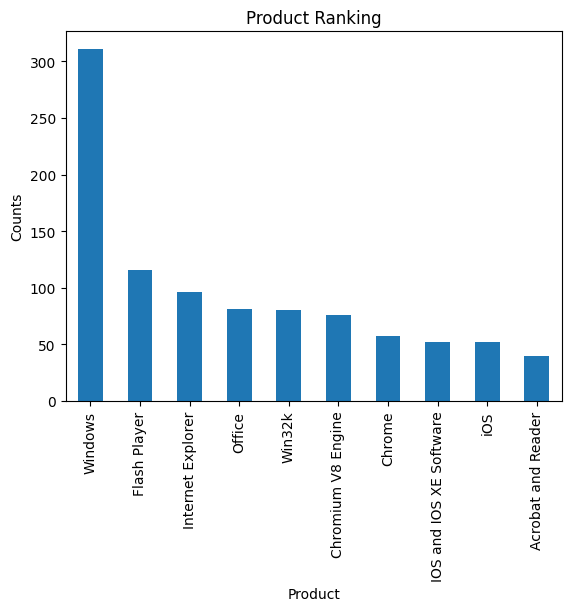

In [24]:
product_rank = df_dropped.groupby('product', as_index=False)['cve_id'].count().sort_values(by = 'cve_id', ascending=False)
product_rank.head(10).plot(kind='bar', x='product', y='cve_id', legend=False)

# Adding titles and labels
plt.title('Product Ranking')
plt.xlabel('Product')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

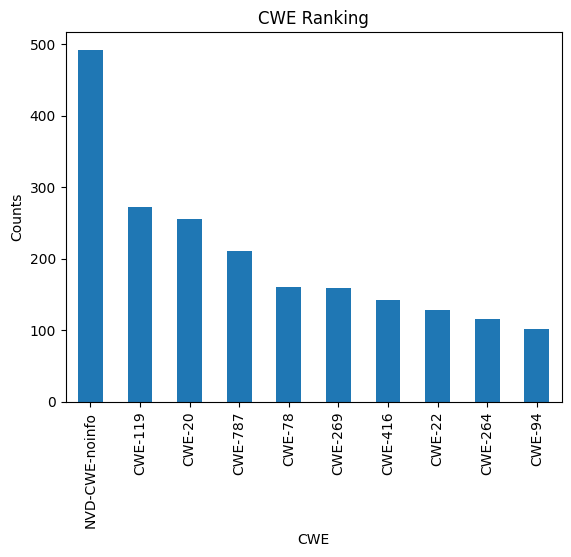

In [25]:
cwe_rank = df_dropped.groupby('cwe', as_index=False)['cve_id'].count().sort_values(by = 'cve_id', ascending=False)
cwe_rank.head(10).plot(kind='bar', x='cwe', y='cve_id', legend=False)

# Adding titles and labels
plt.title('CWE Ranking')
plt.xlabel('CWE')
plt.ylabel('Counts')

In [31]:
time_diff = df_dropped['patch_time'].max() - df_dropped['patch_time'].min()
days = time_diff.total_seconds()/ 86400
days

7256.0

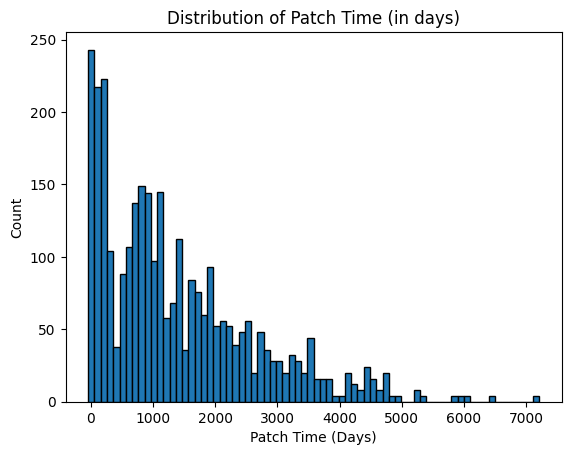

In [41]:

# Step 1: Convert 'due_date' and 'pub_date' to datetime if not already
df_dropped['due_date'] = pd.to_datetime(df_dropped['due_date'])
df_dropped['pub_date'] = pd.to_datetime(df_dropped['pub_date'])

# Step 2: Calculate 'patch_time' (this step is correct as you've done)
df_dropped['patch_time'] = df_dropped['due_date'] - df_dropped['pub_date']

# Step 3: Convert 'patch_time' to days as float
df_dropped['patch_time_days'] = df_dropped['patch_time'].dt.total_seconds() / (86400)

# Step 4: Calculate approx_bins using the 'patch_time_days'
range_width = df_dropped['patch_time_days'].max() - df_dropped['patch_time_days'].min()
desired_bin_size = 100
approx_bins = int(range_width / desired_bin_size)

# Step 5: Plot the histogram using 'patch_time_days'
plt.hist(df_dropped['patch_time_days'], bins=approx_bins, edgecolor='black')

plt.title('Distribution of Patch Time (in days)')
plt.xlabel('Patch Time (Days)')
plt.ylabel('Count')
plt.show()

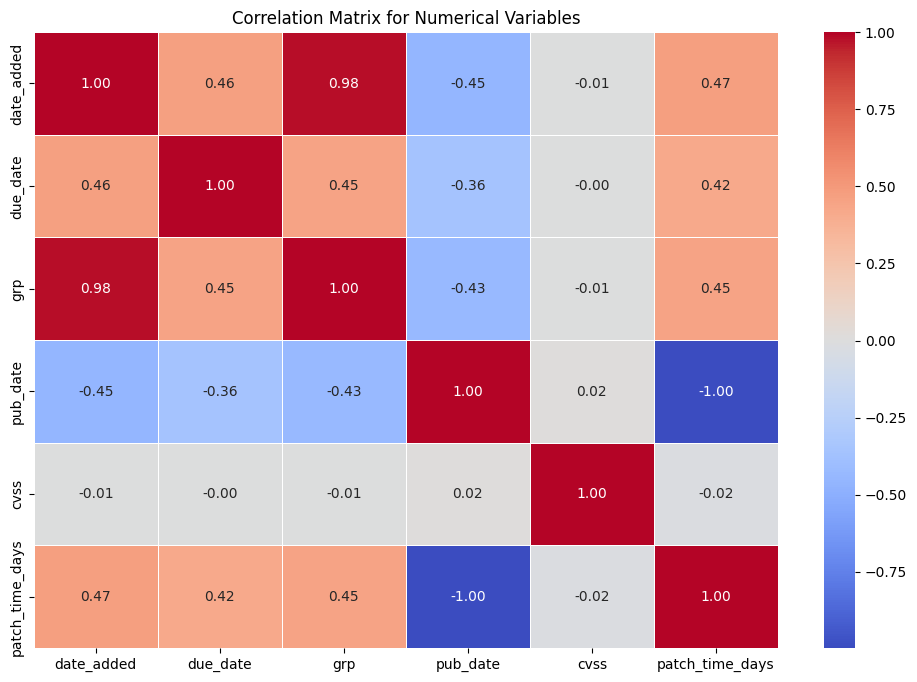

In [44]:
corr_patch = df_dropped.select_dtypes(include = ['float64','bool','datetime64']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_patch, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Numerical Variables')
plt.show()